# **Work flow**

1. Libraries and datasets
2. Explore the data
3. Data cleaning
4. Preparing data set trainig and test
5. Analyze features of the variables
6. Model variables
7. Machine learnig models
8. Compare models

### About the disaster 

The sinking of the Titanic is one of the most infamous shipwrecks in history.
On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.
In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# 1. Libraries and datasets

### 1.1. Libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=7ed0bc79384159547e058f7fa331db91bb63c791419b4e8dcc0f08ab0545315d
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
# Machine Learning
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss

In [3]:
# Plot
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

In [4]:
# Data processing
import numpy as np # linear algebra
import pandas as pd # data processing
# Spark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, lit,row_number
from pyspark.sql.types import FloatType, StringType, IntegerType
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id as m_id
import functools

### 1.2. Get data

We going to develop this proyect with dataframes in pandas and pyspark. Bellow cells in relation with pyspark and pandas are pointed out #sp and #pd respectively

In [5]:
# To use spark, first create a session
spark = SparkSession.builder.master("local[2]").appName("titanic_prediction").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/19 01:15:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
#pandas pd
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [7]:
#pyspark sp
train_data_sp = spark.read.csv("/kaggle/input/titanic/train.csv", inferSchema=True, header=True)
test_data_sp = spark.read.csv("/kaggle/input/titanic/test.csv", inferSchema=True, header=True)

# 2. Explore the data

Before to training any predictive model, or inside realice any calculate, it's important make a descriptive exploration about the data. This method allow us the information of each variable, and look up posibles mistakes. 

º **PassengerId**: unique identifier of the passenger.\
º **Survived**: whether the passenger survived the shipwreck, coded as 0 (no) and 1 (yes). This is the response variable of interest to predict.\
º **Pclass**: class to which the passenger belonged: 1, 2 or 3.\
º **Name**: passenger's name.\
º **Sex**: passenger's sex.\
º **Age**: passenger's age.\
º **SibSp**: number of siblings on the ship.\
º **Parch**: number of parents and children on the ship.\
º **Ticket**: ticket identifier.\
º **Fare**: price paid for the ticket.\
º **Cabin**: identifier of the cabin assigned to the passenger.\
º **Embarked**: port where the passenger embarked.


### 2.1. Shows some data

In [8]:
# pd shows some data
train_data.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [9]:
# sp shows some data
train_data_sp.show(4)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
only showing top 4 rows



### 2.2. Types of each column

In [10]:
# pd
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
# pd
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [12]:
# sp
train_data_sp.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [13]:
# sp
test_data_sp.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



**Warning:** the age not have the correct type

### 2.3. Observe full data

In [14]:
#merge test and train pd
merge_data = pd.concat([train_data.drop('Survived',axis=1), test_data])
merge_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [15]:
#merge test and train sp
merge_data_sp = train_data_sp.drop("Survived").unionByName(test_data_sp)
merge_data_sp.show()

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|     3|    Moran, Mr. James|  male|null|    0|    0|          330877| 8.4583| null|       Q|
|          7|     1|McCarthy, Mr. Tim...|  mal

### 2.4. Number of observations and missing values

In [16]:
# Dimension pd
merge_data.shape

(1309, 11)

In [17]:
# Dimension sp
((merge_data_sp.count(), len(merge_data_sp.columns)))

(1309, 11)

In [18]:
# Duplicate data pd
merge_data.duplicated().sum()

0

In [19]:
# Duplicate data sp
merge_data_sp.groupBy(merge_data_sp.columns).count().filter(col("count")>1).groupBy().sum().collect()

[Row(sum(PassengerId)=None, sum(Pclass)=None, sum(Age)=None, sum(SibSp)=None, sum(Parch)=None, sum(Fare)=None, sum(count)=None)]

In [20]:
# missing datatrain pd
train_data.isna().sum().sort_values()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age            177
Cabin          687
dtype: int64

In [21]:
merge_data.isna().sum().sort_values()

PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Embarked          2
Age             263
Cabin          1014
dtype: int64

In [22]:
# missing datatrain sp
train_data_sp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_data_sp.columns]
   ).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [23]:
merge_data_sp.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in merge_data_sp.columns]).show()

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0|263|    0|    0|     0|   1| 1014|       2|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+



**Warning:**

In [24]:
 print('"Cabin" has many values null, is not a good predictor. Maybe this can be not into the model ',round(1014/1039*100,3))

"Cabin" has many values null, is not a good predictor. Maybe this can be not into the model  97.594


# 3. Data cleaning

### 3.1. Analyze atipical values

In [25]:
#pd
merge_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [26]:
#sp
merge_data_sp.summary().show()

+-------+-----------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+
|summary|      PassengerId|            Pclass|                Name|   Sex|               Age|             SibSp|             Parch|            Ticket|              Fare|Cabin|Embarked|
+-------+-----------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+
|  count|             1309|              1309|                1309|  1309|              1046|              1309|              1309|              1309|              1308|  295|    1307|
|   mean|            655.0| 2.294881588999236|                null|  null|29.881137667304014|0.4988540870893812|0.3850267379679144| 249039.1368861024| 33.29547928134553| null|    null|
| stddev|378.0200611960517|0.8378360189701275|                null|  null| 

**Warning:** The minimun age is an atipic data, we going tho see the top 10 in detail 

In [27]:
#pd
merge_data.nsmallest(10, ['Age'])

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
354,1246,3,"Dean, Miss. Elizabeth Gladys Millvina""""",female,0.17,1,2,C.A. 2315,20.5750,NaN,S
201,1093,3,"Danbom, Master. Gilbert Sigvard Emanuel",male,0.33,0,2,347080,14.4000,NaN,S
803,804,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
755,756,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
469,470,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
281,1173,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
78,79,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
831,832,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S
307,1199,3,"Aks, Master. Philip Frank",male,0.83,0,1,392091,9.3500,NaN,S


In [28]:
#sp
(merge_data_sp.filter(merge_data_sp.Age.isNotNull())).sort('Age', ascending=True).show(10)

+-----------+------+--------------------+------+----+-----+-----+------------------+-------+-----+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|            Ticket|   Fare|Cabin|Embarked|
+-----------+------+--------------------+------+----+-----+-----+------------------+-------+-----+--------+
|       1246|     3|Dean, Miss. Eliza...|female|0.17|    1|    2|         C.A. 2315| 20.575| null|       S|
|       1093|     3|Danbom, Master. G...|  male|0.33|    0|    2|            347080|   14.4| null|       S|
|        804|     3|Thomas, Master. A...|  male|0.42|    0|    1|              2625| 8.5167| null|       C|
|        756|     2|Hamalainen, Maste...|  male|0.67|    1|    1|            250649|   14.5| null|       S|
|        645|     3|Baclini, Miss. Eu...|female|0.75|    2|    1|              2666|19.2583| null|       C|
|       1173|     3|Peacock, Master. ...|  male|0.75|    1|    1|SOTON/O.Q. 3101315| 13.775| null|       S|
|        470|     3|Baclini,

We let's asume that decimal values <1 is a typing error. In this way 0.17 -> 17 years. Values >1 going to be round 

In [29]:
#pd
merge_data.insert(4, "Age_new", [Age*100 if Age < 1 else Age for Age in merge_data.Age]) 
merge_data.nsmallest(10, ['Age'])

,PassengerId,Pclass,Name,Sex,Age_new,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
354,1246,3,"Dean, Miss. Elizabeth Gladys Millvina""""",female,17.0,0.17,1,2,C.A. 2315,20.5750,NaN,S
201,1093,3,"Danbom, Master. Gilbert Sigvard Emanuel",male,33.0,0.33,0,2,347080,14.4000,NaN,S
803,804,3,"Thomas, Master. Assad Alexander",male,42.0,0.42,0,1,2625,8.5167,NaN,C
755,756,2,"Hamalainen, Master. Viljo",male,67.0,0.67,1,1,250649,14.5000,NaN,S
469,470,3,"Baclini, Miss. Helene Barbara",female,75.0,0.75,2,1,2666,19.2583,NaN,C
644,645,3,"Baclini, Miss. Eugenie",female,75.0,0.75,2,1,2666,19.2583,NaN,C
281,1173,3,"Peacock, Master. Alfred Edward",male,75.0,0.75,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S
78,79,2,"Caldwell, Master. Alden Gates",male,83.0,0.83,0,2,248738,29.0000,NaN,S
831,832,2,"Richards, Master. George Sibley",male,83.0,0.83,1,1,29106,18.7500,NaN,S
307,1199,3,"Aks, Master. Philip Frank",male,83.0,0.83,0,1,392091,9.3500,NaN,S


In [30]:
#sp
count = 0 
valor = []
for i in merge_data_sp.sort(F.col("PassengerId")).collect():
    count += 1
    if isinstance(i["Age"], float) and i["Age"] < 1:
        valor.append((count,i["Age"]*100))
    else:
        valor.append((count,i["Age"]))

#valor = [(count,i["Age"]*100) if isinstance(i["Age"], float) and i["Age"] < 1 else (count,i["Age"]) for i in merge_data_sp.collect()]
columns = ['id','Age_new']
aux_col = spark.createDataFrame(valor).toDF(*columns)
#aux_col.show()

In [31]:
#sp
#merge_data_sp = merge_data_sp.coalesce(1).withColumn("rowId", m_id()+1)
merge_data_sp = merge_data_sp.join(aux_col,merge_data_sp.PassengerId ==  aux_col.id,"left").select(merge_data_sp["*"], aux_col.Age_new)  
(merge_data_sp.filter(merge_data_sp.Age.isNotNull())).sort('Age', ascending=True).show(10)

+-----------+------+--------------------+------+----+-----+-----+------------------+-------+-----+--------+-------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|            Ticket|   Fare|Cabin|Embarked|Age_new|
+-----------+------+--------------------+------+----+-----+-----+------------------+-------+-----+--------+-------+
|       1246|     3|Dean, Miss. Eliza...|female|0.17|    1|    2|         C.A. 2315| 20.575| null|       S|   17.0|
|       1093|     3|Danbom, Master. G...|  male|0.33|    0|    2|            347080|   14.4| null|       S|   33.0|
|        804|     3|Thomas, Master. A...|  male|0.42|    0|    1|              2625| 8.5167| null|       C|   42.0|
|        756|     2|Hamalainen, Maste...|  male|0.67|    1|    1|            250649|   14.5| null|       S|   67.0|
|        645|     3|Baclini, Miss. Eu...|female|0.75|    2|    1|              2666|19.2583| null|       C|   75.0|
|        470|     3|Baclini, Miss. He...|female|0.75|    2|    1|       

### 3.2 Impute data to missing values

In [32]:
#pd
merge_data['Embarked'].fillna((merge_data['Embarked'].mode()[0]), inplace = True)
merge_data['Age_new'].fillna((merge_data['Age_new'].median()), inplace = True)
merge_data['Fare'].fillna((merge_data['Fare'].mean()), inplace = True)

In [33]:
#sp
ipte_Embarked = merge_data_sp.groupby("Embarked").count().orderBy("count", ascending=False).first()[0]
merge_data_sp = merge_data_sp.na.fill(value=ipte_Embarked,subset=["Embarked"])
ipte_Age_new = merge_data_sp.approxQuantile("Age_new", [0.5], 0.25)[0]
merge_data_sp = merge_data_sp.na.fill(value=ipte_Age_new,subset=["Age_new"])
ipte_Fare = merge_data_sp.agg({'Fare':'mean'}).collect()[0][0]
merge_data_sp = merge_data_sp.na.fill(value=ipte_Fare,subset=["Fare"])

In [34]:
#pd
#change type float to int
merge_data[['Age_new']] = merge_data[['Age_new']].astype(int)

In [35]:
#sp
#change type float to int
merge_data_sp = merge_data_sp.withColumn("Age_new",col("Age_new").cast(IntegerType()))

# 4. Preparing data set trainig and test

In [36]:
#pd
dftrain = merge_data[merge_data['PassengerId'].between(1,891)]
dftest = merge_data[merge_data['PassengerId'].between(892,1309)]

In [37]:
#pd add column Survived
dftrain = pd.merge(dftrain, train_data[['PassengerId','Survived']], how="left", on= "PassengerId")

In [38]:
#sp
dftrain_sp = merge_data_sp.filter(merge_data_sp.PassengerId.between(1,891))
dftest_sp = merge_data_sp.filter(merge_data_sp.PassengerId.between(892,1309))

In [39]:
#sp add column Survived
train_data_sp = train_data_sp.toDF(*train_data_sp.columns)
dftrain_sp = dftrain_sp.join(train_data_sp,dftrain_sp.PassengerId ==  train_data_sp.PassengerId,"left").select(dftrain_sp["*"], train_data_sp["Survived"])

# 5. Analyze features of the variables

Let's take a look at the features of each variable with respect to the response ("Survived")

### 5.1. Continue variables

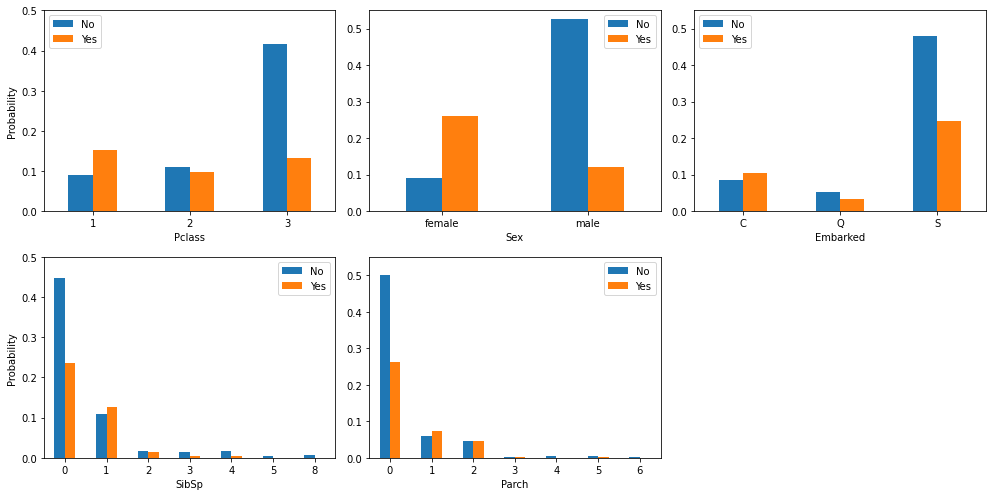

In [40]:
# pd
def prob_df(variable, df):
    rating_probs_no = pd.DataFrame(
        df[df.Survived == 0].groupby(variable).size().div(len(df)))
    rating_probs_yes = pd.DataFrame(
        df[df.Survived == 1].groupby(variable).size().div(len(df)))
    df_2 = rating_probs_no.merge(rating_probs_yes,
                                 how='outer',
                                 left_index=True,
                                 right_index=True)
    df_2.columns = ['No', 'Yes']
    return df_2

fig, axes = plt.subplots(2, 3, figsize=(14, 7))
prob_df('Pclass',dftrain).plot(ax=axes[0, 0], kind='bar', ylim=(0, 0.5), rot=0)
axes[0, 0].set_ylabel('Probability')
prob_df('Sex',dftrain).plot(ax=axes[0, 1], kind='bar', ylim=(0, 0.55), rot=0)
prob_df('SibSp',dftrain).plot(ax=axes[1, 0], kind='bar', ylim=(0, 0.5), rot=0)
axes[1, 0].set_ylabel('Probability')
prob_df('Embarked',dftrain).plot(ax=axes[0, 2],kind='bar', ylim=(0, 0.55), rot=0)
prob_df('Parch',dftrain).plot(ax=axes[1, 1],kind='bar', ylim=(0, 0.55), rot=0)
plt.tight_layout()

fig.delaxes(axes[1,2])


# ddd = dftrain_sp.filter(dftrain_sp.Survived == 0).groupby('Pclass').count()
# ddd1 = dftrain_sp.filter(dftrain_sp.Survived == 0).groupby('Pclass').count()
# ddd.join(ddd,ddd1.Pclass ==  ddd.Pclass,"left") \
#      .show(truncate=False)


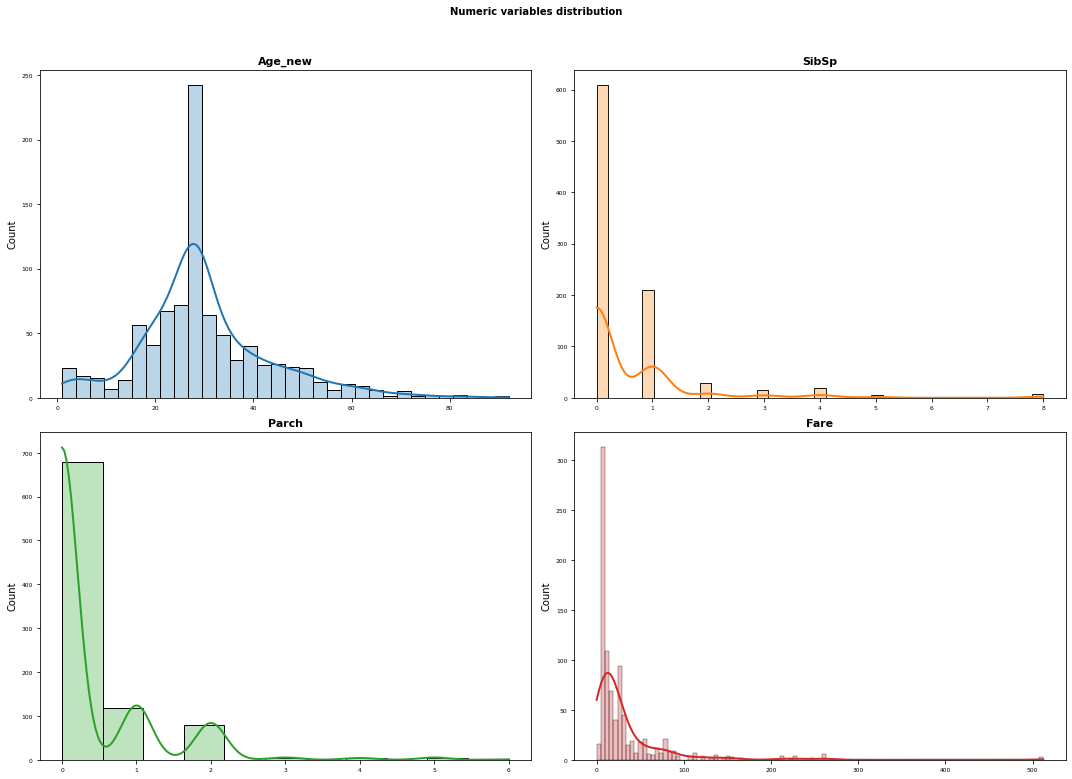

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))
axes = axes.flat
columnas_numeric = dftrain[['Age_new','SibSp','Parch','Fare']]
for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = dftrain,
        x       = colum,
        stat    = "count",
        color   = (list(plt.rcParams['axes.prop_cycle'])*3)[i]["color"],
        kde     = True,
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 11, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Numeric variables distribution', fontsize = 10, fontweight = "bold");

### 5.2. Categorical variables

In [42]:
dftrain['Age_grp'] = dftrain['Age_new'].apply(
    lambda x: "Young" if x <= 18
    else ("Adult" if x > 18 and x <= 60
    else ("Old" if x > 60
    else 9999)))

dftrain['Age_grp'].value_counts()

Adult    731
Young    132
Old       28
Name: Age_grp, dtype: int64

In [43]:
Q1 = dftrain.Fare.quantile(0.25)
Q2 = dftrain.Fare.quantile(0.50)
Q3 = dftrain.Fare.quantile(0.75)
dftrain['Fare_grp'] = dftrain['Fare'].apply(
    lambda x: "Low" if x <= Q1
    else ("MediumLow" if x > Q1 and x <= Q2
    else ("MediumHigh" if x >  Q2 and x <= Q3
    else "High")))

dftrain['Fare_grp'].value_counts()

MediumLow     224
Low           223
High          222
MediumHigh    222
Name: Fare_grp, dtype: int64

In [44]:
dftrain['Family'] = dftrain['SibSp'] + dftrain['Parch']
dftrain['Family_grp'] = dftrain['Family'].apply(
    lambda x: "Single" if x == 0
    else ("Medium" if x > 0  and x < 5
    else ("Big" if x >=  5 
    else "bad")))

dftrain['Family_grp'].value_counts()

Single    537
Medium    307
Big        47
Name: Family_grp, dtype: int64

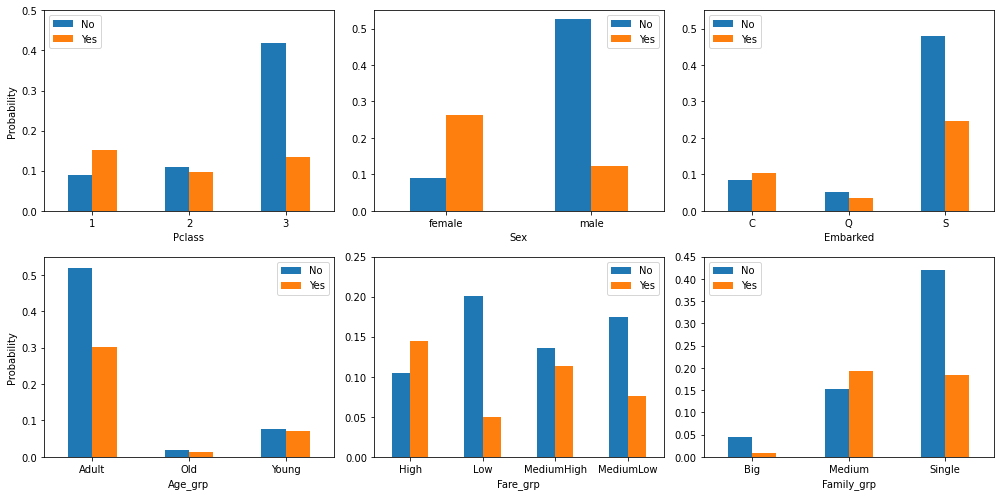

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
prob_df('Pclass',dftrain).plot(ax=axes[0, 0], kind='bar', ylim=(0, 0.5), rot=0)
axes[0, 0].set_ylabel('Probability')
prob_df('Sex',dftrain).plot(ax=axes[0, 1], kind='bar', ylim=(0, 0.55), rot=0)
prob_df('Age_grp',dftrain).plot(ax=axes[1, 0], kind='bar', ylim=(0, 0.55), rot=0)
axes[1, 0].set_ylabel('Probability')
prob_df('Embarked',dftrain).plot(ax=axes[0, 2],kind='bar', ylim=(0, 0.55), rot=0)
prob_df('Fare_grp',dftrain).plot(ax=axes[1, 1],kind='bar', ylim=(0, 0.25), rot=0)
prob_df('Family_grp',dftrain).plot(ax=axes[1, 2],kind='bar', ylim=(0, 0.45), rot=0)
plt.tight_layout()

In [46]:
merge_data['Age_grp'] = merge_data['Age_new'].apply(
    lambda x: "Young" if x <= 18
    else ("Adult" if x > 18 and x <= 60
    else ("Old" if x > 60
    else 9999)))

Q1 = merge_data.Fare.quantile(0.25)
Q2 = merge_data.Fare.quantile(0.50)
Q3 = merge_data.Fare.quantile(0.75)
merge_data['Fare_grp'] = merge_data['Fare'].apply(
    lambda x: "Low" if x <= Q1
    else ("MediumLow" if x > Q1 and x <= Q2
    else ("MediumHigh" if x >  Q2 and x <= Q3
    else "High")))

merge_data['Family'] = merge_data['SibSp'] + merge_data['Parch']
merge_data['Family_grp'] = merge_data['Family'].apply(
    lambda x: "Single" if x == 0
    else ("Medium" if x > 0  and x < 5
    else ("Big" if x >=  5 
    else "bad")))

# 6. Model variables

### 6.1 Select features

In [47]:
model_columns = merge_data[['Pclass','Sex','Embarked','Age_grp','Fare_grp','Family_grp']]
model_columns.head()

,Pclass,Sex,Embarked,Age_grp,Fare_grp,Family_grp
0,3,male,S,Adult,Low,Medium
1,1,female,C,Adult,High,Medium
2,3,female,S,Adult,MediumLow,Single
3,1,female,S,Adult,High,Medium
4,3,male,S,Adult,MediumLow,Single


In [48]:
data_model = pd.get_dummies(model_columns, drop_first = False) # Encoding categorical variables
data_model.head(5)

,Pclass,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_grp_Adult,Age_grp_Old,Age_grp_Young,Fare_grp_High,Fare_grp_Low,Fare_grp_MediumHigh,Fare_grp_MediumLow,Family_grp_Big,Family_grp_Medium,Family_grp_Single
0,3,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0
1,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0
2,3,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1
3,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0
4,3,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1


### 6.2 Correlation matrix

In [49]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = data_model.corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)


,variable_1,variable_2,r,abs_r
33,Sex_male,Sex_female,-1.000000,1.000000
18,Sex_female,Sex_male,-1.000000,1.000000
254,Family_grp_Single,Family_grp_Medium,-0.906623,0.906623
239,Family_grp_Medium,Family_grp_Single,-0.906623,0.906623
134,Age_grp_Young,Age_grp_Adult,-0.888102,0.888102
104,Age_grp_Adult,Age_grp_Young,-0.888102,0.888102
83,Embarked_S,Embarked_C,-0.778262,0.778262
53,Embarked_C,Embarked_S,-0.778262,0.778262
9,Pclass,Fare_grp_High,-0.605625,0.605625
144,Fare_grp_High,Pclass,-0.605625,0.605625


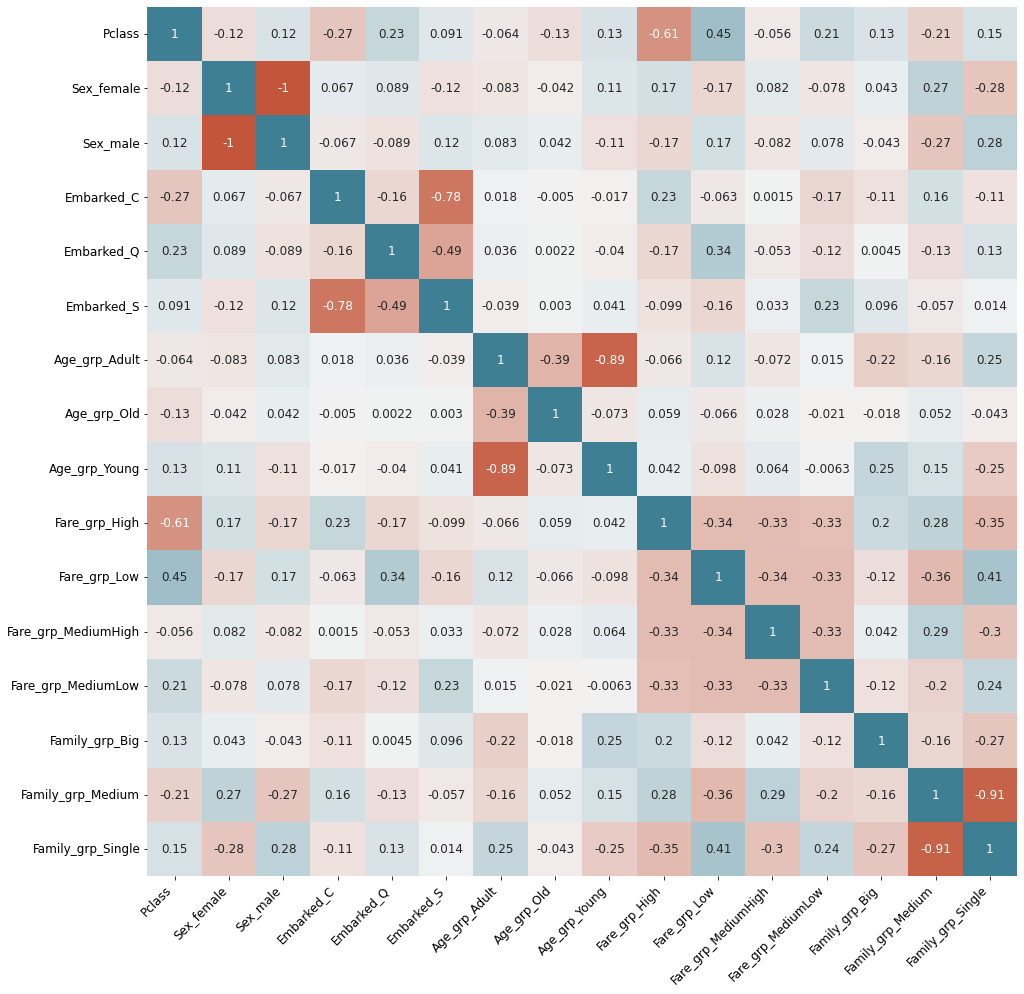

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 12},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 12)

In [51]:
# Droppinbg some unnecesary encoded features correlation above 0.9
data_model.drop(['Sex_female', 'Family_grp_Medium'], axis = 1, inplace = True)
data_model.head(5)

,Pclass,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_grp_Adult,Age_grp_Old,Age_grp_Young,Fare_grp_High,Fare_grp_Low,Fare_grp_MediumHigh,Fare_grp_MediumLow,Family_grp_Big,Family_grp_Single
0,3,1,0,0,1,1,0,0,0,1,0,0,0,0
1,1,0,1,0,0,1,0,0,1,0,0,0,0,0
2,3,0,0,0,1,1,0,0,0,0,0,1,0,1
3,1,0,0,0,1,1,0,0,1,0,0,0,0,0
4,3,1,0,0,1,1,0,0,0,0,0,1,0,1


In [52]:
scaler = StandardScaler()
df_std = scaler.fit_transform(data_model)
df_std = pd.DataFrame(data = df_std,columns = data_model.columns)
df_std.head(4)

,Pclass,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_grp_Adult,Age_grp_Old,Age_grp_Young,Fare_grp_High,Fare_grp_Low,Fare_grp_MediumHigh,Fare_grp_MediumLow,Family_grp_Big,Family_grp_Single
0,0.841916,0.743497,-0.50977,-0.32204,0.655011,0.456815,-0.179818,-0.405698,-0.573528,1.698315,-0.578232,-0.568823,-0.219177,-1.233758
1,-1.546098,-1.344995,1.96167,-0.32204,-1.526692,0.456815,-0.179818,-0.405698,1.743595,-0.588819,-0.578232,-0.568823,-0.219177,-1.233758
2,0.841916,-1.344995,-0.50977,-0.32204,0.655011,0.456815,-0.179818,-0.405698,-0.573528,-0.588819,-0.578232,1.758017,-0.219177,0.810532
3,-1.546098,-1.344995,-0.50977,-0.32204,0.655011,0.456815,-0.179818,-0.405698,1.743595,-0.588819,-0.578232,-0.568823,-0.219177,-1.233758


In [53]:
#check the level of umbalece response model
dftrain.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [54]:
dftrain_final = df_std[:891]
dftest_final = df_std[891:]

# 7. Machine learnig models

In [55]:
y_train = dftrain.Survived
X_train, X_test, y_train, y_test = train_test_split(dftrain_final, y_train, test_size = 0.20, random_state = 42)

### 7.1. LogisticRegression

In [56]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

lr_acc = accuracy_score(y_test, lr.predict(X_test)) 
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
lr_log = log_loss(y_test,lr.predict(X_test))

print(f"log_loss: {lr_log}")
print(f"AUC - Test Set: {lr_auc}")
print(f"Training Accuracy of Logistic Regression is {accuracy_score(y_train, lr.predict(X_train))}")
print(f"Test Accuracy of Logistic Regression is {lr_acc}")

print(f"Confusion Matrix : \n {confusion_matrix(y_test, lr.predict(X_test))}")
print(f"Classification Report : \n {classification_report(y_test, lr.predict(X_test))}")

log_loss: 8.104168713573817
AUC - Test Set: 0.870913770913771
Training Accuracy of Logistic Regression is 0.7963483146067416
Test Accuracy of Logistic Regression is 0.7653631284916201
Confusion Matrix : 
 [[83 22]
 [20 54]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       105
           1       0.71      0.73      0.72        74

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



### 7.2. DecisionTreeClassifier

In [57]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

dtc_acc = accuracy_score(y_test, dtc.predict(X_test))
dtc_auc = roc_auc_score(y_test, dtc.predict_proba(X_test)[:, 1])
dtc_log = log_loss(y_test,dtc.predict(X_test))

print(f"log_loss: {dtc_log}")
print(f"AUC - Test Set: {dtc_auc}")
print(f"Training Accuracy of Decision Tree Classifier is {accuracy_score(y_train, dtc.predict(X_train))}")
print(f"Test Accuracy of Decision Tree Classifier is {dtc_acc} \n")

print(f"Confusion Matrix : \n{confusion_matrix(y_test, dtc.predict(X_test))}\n")
print(f"Classification Report : \n {classification_report(y_test, dtc.predict(X_test))}")

log_loss: 7.332312278062562
AUC - Test Set: 0.8762548262548262
Training Accuracy of Decision Tree Classifier is 0.8539325842696629
Test Accuracy of Decision Tree Classifier is 0.7877094972067039 

Confusion Matrix : 
[[92 13]
 [25 49]]

Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       105
           1       0.79      0.66      0.72        74

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



### 7.3. RandomForestClassifier

In [58]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)

rd_clf_acc = accuracy_score(y_test, rd_clf.predict(X_test))
rd_clf_auc = roc_auc_score(y_test, rd_clf.predict_proba(X_test)[:, 1])
rd_clf_log = log_loss(y_test,rd_clf.predict(X_test))

print(f"log_loss: {rd_clf_log}")
print(f"AUC - Test Set: {rd_clf_auc}")
print(f"Training Accuracy of Random Forest Classifier is {accuracy_score(y_train, rd_clf.predict(X_train))}")
print(f"Test Accuracy of Random Forest Classifier is {rd_clf_acc} \n")

print(f"Confusion Matrix : \n{confusion_matrix(y_test, rd_clf.predict(X_test))}\n")
print(f"Classification Report : \n {classification_report(y_test, rd_clf.predict(X_test))}")

log_loss: 7.139362687015184
AUC - Test Set: 0.8826254826254825
Training Accuracy of Random Forest Classifier is 0.8539325842696629
Test Accuracy of Random Forest Classifier is 0.7932960893854749 

Confusion Matrix : 
[[91 14]
 [23 51]]

Classification Report : 
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       105
           1       0.78      0.69      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



### 7.4. GradientBoostingClassifier

In [59]:
gb = GradientBoostingClassifier() #
gb.fit(X_train, y_train)

gb_acc = accuracy_score(y_test, gb.predict(X_test))
gb_auc = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
gb_log = log_loss(y_test,gb.predict(X_test))

print(f"log_loss: {gb_log}")
print(f"AUC - Test Set: {gb_auc}")
print(f"Training Accuracy of Gradient Boosting Classifier is {accuracy_score(y_train, gb.predict(X_train))}")
print(f"Test Accuracy of Gradient Boosting Classifier is {gb_acc} \n")

print(f"Confusion Matrix : \n{confusion_matrix(y_test, gb.predict(X_test))}\n")
print(f"Classification Report : \n {classification_report(y_test, gb.predict(X_test))}")

log_loss: 7.33232121211206
AUC - Test Set: 0.88005148005148
Training Accuracy of Gradient Boosting Classifier is 0.8412921348314607
Test Accuracy of Gradient Boosting Classifier is 0.7877094972067039 

Confusion Matrix : 
[[90 15]
 [23 51]]

Classification Report : 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       105
           1       0.77      0.69      0.73        74

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



### 7.5. XGBClassifier

In [60]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, y_train)

xgb_acc = accuracy_score(y_test, xgb.predict(X_test))
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
xgb_log = log_loss(y_test,xgb.predict(X_test))

print(f"log_loss: {xgb_log}")
print(f"AUC - Test Set: {xgb_auc}")
print(f"Training Accuracy of XgBoost is {accuracy_score(y_train, xgb.predict(X_train))}")
print(f"Test Accuracy of XgBoost is {xgb_acc} \n")

print(f"Confusion Matrix : \n{confusion_matrix(y_test, xgb.predict(X_test))}\n")
print(f"Classification Report : \n {classification_report(y_test, xgb.predict(X_test))}")

log_loss: 7.525270803159437
AUC - Test Set: 0.8855855855855856
Training Accuracy of XgBoost is 0.8539325842696629
Test Accuracy of XgBoost is 0.7821229050279329 

Confusion Matrix : 
[[91 14]
 [25 49]]

Classification Report : 
               precision    recall  f1-score   support

           0       0.78      0.87      0.82       105
           1       0.78      0.66      0.72        74

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



### 7.6. Support Vector Machine

In [61]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)

svc_acc = accuracy_score(y_test, svc.predict(X_test))
svc_auc = roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1])
svc_log = log_loss(y_test,svc.predict(X_test))

print(f"log_loss: {svc_log}")
print(f"AUC - Test Set: {svc_auc}")
print(f"Training Accuracy of Support Vector Machines is {accuracy_score(y_train, svc.predict(X_train))}")
print(f"Test Accuracy of Support Vector Machines is {svc_acc} \n")

print(f"Confusion Matrix : \n{confusion_matrix(y_test, svc.predict(X_test))}\n")
print(f"Classification Report : \n {classification_report(y_test, svc.predict(X_test))}")

log_loss: 7.139376088089435
AUC - Test Set: 0.8023166023166023
Training Accuracy of Support Vector Machines is 0.8286516853932584
Test Accuracy of Support Vector Machines is 0.7932960893854749 

Confusion Matrix : 
[[88 17]
 [20 54]]

Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       105
           1       0.76      0.73      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.79      0.79      0.79       179



### 7.7. KNeighborsClassifier

In [62]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

knn_acc = accuracy_score(y_test, knn.predict(X_test))
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
knn_log = log_loss(y_test,knn.predict(X_test))

print(f"log_loss: {knn_log}")
print(f"AUC - Test Set: {knn_auc}")
print(f"Training Accuracy of KNeighbors is {accuracy_score(y_train, knn.predict(X_train))}")
print(f"Test Accuracy of KNeighbors is {knn_acc} \n")

print(f"Confusion Matrix : \n{confusion_matrix(y_test, knn.predict(X_test))}\n")
print(f"Classification Report : \n {classification_report(y_test, knn.predict(X_test))}")


log_loss: 7.525279737208937
AUC - Test Set: 0.8343629343629343
Training Accuracy of KNeighbors is 0.8300561797752809
Test Accuracy of KNeighbors is 0.7821229050279329 

Confusion Matrix : 
[[89 16]
 [23 51]]

Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.85      0.82       105
           1       0.76      0.69      0.72        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



### 7.8. CatBoostClassifier

In [63]:
cb = CatBoostClassifier( learning_rate = 0.1, max_depth = 5, n_estimators = 180, verbose=False)
cb.fit(X_train, y_train)

cb_acc = accuracy_score(y_test, cb.predict(X_test))
cb_auc = roc_auc_score(y_test, cb.predict_proba(X_test)[:, 1])
cb_log = log_loss(y_test,cb.predict(X_test))

print(f"log_loss: {cb_log}")
print(f"AUC - Test Set: {cb_auc}")
print(f"Training Accuracy of CatBoost is {accuracy_score(y_train, cb.predict(X_train))}")
print(f"Test Accuracy of CatBoost is {cb_acc} \n")

print(f"Confusion Matrix : \n{confusion_matrix(y_test, cb.predict(X_test))}\n")
print(f"Classification Report : \n {classification_report(y_test, cb.predict(X_test))}")

log_loss: 6.753445636821431
AUC - Test Set: 0.8891891891891892
Training Accuracy of CatBoost is 0.848314606741573
Test Accuracy of CatBoost is 0.8044692737430168 

Confusion Matrix : 
[[93 12]
 [23 51]]

Classification Report : 
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



# 8. Compare models

### 8.1 Analyze model metrics

In [64]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'Decision Tree Classifier', 'Random Forest Classifier',
             'Gradient Boosting Classifier', 'XgBoost','SVC','KNeighbors', 'CatBoost'],
    'Score' : [lr_acc, dtc_acc, rd_clf_acc, gb_acc, xgb_acc,svc_acc,knn_acc,cb_acc],
    'AUC' : [lr_auc, dtc_auc, rd_clf_auc, gb_auc, xgb_auc,svc_auc,knn_auc,cb_auc],
    'log_loss' : [lr_log, dtc_log, rd_clf_log, gb_log, xgb_log,svc_log,knn_log,cb_log]
})

models["Score"] = (models["Score"] * 100).round(2)
models["AUC"] = (models["AUC"] * 100).round(2)
models["log_loss"] = (models["log_loss"]).round(2)

models.sort_values(by = ['AUC', 'Score','log_loss'], ascending = False)

,Model,Score,AUC,log_loss
7,CatBoost,80.45,88.92,6.75
4,XgBoost,78.21,88.56,7.53
2,Random Forest Classifier,79.33,88.26,7.14
3,Gradient Boosting Classifier,78.77,88.01,7.33
1,Decision Tree Classifier,78.77,87.63,7.33
0,Logistic Regression,76.54,87.09,8.10
6,KNeighbors,78.21,83.44,7.53
5,SVC,79.33,80.23,7.14


### 8.2 Submission answer

In [65]:
# select the best model found
gb_prediction = gb.predict(dftest_final) 
prediction = pd.DataFrame(gb_prediction)
submission = pd.read_csv('../input/titanic/gender_submission.csv')
submission['Survived'] = prediction
submission.to_csv('Submission.csv', index = False)

In [66]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: left;
    vertical-align: middle;
    horizontal-align: middle;
}
h1,h2 {
    text-align: left;
    background-color: skyblue;
    padding: 20px;
    margin: 0;
    color: black;
    font-family: "Lucida Console";
    border-radius: 0px
}

h3 {
    text-align: left;
    border-style: solid;
    border-width: 3px;
    padding: 12px;
    margin: 0;
    color: black;
    font-family: "Lucida Console";
    border-radius: 0px;
    border-color: gold;
}

body, p {
    font-family: "Lucida Console";
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: "Lucida Console";
    color: purple;
}
</style>
""")